## Список команды



1.   Харлов Максим @maksimkharlovv
2.   Лещишин Роман @Roman36519
3.   Неустроев Илья @NeustroevIL
4.   Зайнуллин Венер @zvmarsovich
5.   Cавельев Денис @DenisSavelev2025
6.   Метиекам Коаье Мануэль Патрисия



## Ссылка на GitHub
https://github.com/IlyyaNeustroev/ML-2025-practice-case-3

## Описание проекта

Разработка модели, которая на основе исторических погодных данных и данных об уровне воды предсказывает текущий уровень воды и вероятность наводнения.

## Установка необходимых библиотек в виртуальное окружение

In [ ]:
! pip install -r requirements.txt -q
! pip install numpy==2.1.3
! pip install matplotlib==3.10.0
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


## Загрузка библотек

In [ ]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

DATA_URL = "https://raw.githubusercontent.com/IlyyaNeustroev/ML-2025-practice-case-3/0f00f3ed0bc5b111c5f9f70244676a1e3523ca7a/DA/PythonProject8/train.csv"
DATA_TEST_URL = "https://raw.githubusercontent.com/IlyyaNeustroev/ML-2025-practice-case-3/refs/heads/main/DA/PythonProject8/test.csv"

# Данные

## Загрузка данных

**Каждый столбец-фактор, влияющий на вероятность затопления:**

*   id-уникальный идентификатор записи
*   MonsoonIntensity-интенсивность муссонных дождей
*   TopographyDrainage-особенности рельефа и водоотведения
*   RiverManagement-управление реками
*   Deforestation-вырубка лесов
*   Urbanization-уровень урбанизации
*   ClimateChange-влияние изменения климата
*   DamsQuality-качество плотин
*   Siltation-зарастание осадками
*   AgriculturalPractices-сельскохозяйственные практики
*   Encroachments-захват территорий
*   IneffectiveDisasterPreparedness-неэффективность подготовки к ЧС
*   DrainageSystems-состояние дренажных систем
*   CoastalVulnerability-уязвимость прибрежных зон
*   Landslides-оползни
*   Watersheds-состояние водосборных бассейнов
*   DeterioratingInfrastructure-ухудшение инфраструктуры
*   PopulationScore-показатели населения (плотность, рост)
*   WetlandLoss-потеря водно-болотных угодий
*   InadequatePlanning-недостаточное планирование территорий
*   PoliticalFactors-политические факторы
*   FloodProbability-целевая переменная (только в train.csv), вероятность затопления




In [ ]:
df_train = pd.read_csv(DATA_URL)
df_train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [ ]:
df_train.set_index("id", inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117957 entries, 0 to 1117956
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1117957 non-null  int64  
 1   TopographyDrainage               1117957 non-null  int64  
 2   RiverManagement                  1117957 non-null  int64  
 3   Deforestation                    1117957 non-null  int64  
 4   Urbanization                     1117957 non-null  int64  
 5   ClimateChange                    1117957 non-null  int64  
 6   DamsQuality                      1117957 non-null  int64  
 7   Siltation                        1117957 non-null  int64  
 8   AgriculturalPractices            1117957 non-null  int64  
 9   Encroachments                    1117957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1117957 non-null  int64  
 11  DrainageSystems                  1117957 non-null  int6

In [ ]:
df_train = df_train.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower())
df_train.columns

Index(['monsoon_intensity', 'topography_drainage', 'river_management',
       'deforestation', 'urbanization', 'climate_change', 'dams_quality',
       'siltation', 'agricultural_practices', 'encroachments',
       'ineffective_disaster_preparedness', 'drainage_systems',
       'coastal_vulnerability', 'landslides', 'watersheds',
       'deteriorating_infrastructure', 'population_score', 'wetland_loss',
       'inadequate_planning', 'political_factors', 'flood_probability'],
      dtype='object')

In [ ]:
df_test = pd.read_csv(DATA_TEST_URL)
df_test.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,...,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,...,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,...,7,9,2,5,5,2,3,6,8,3
3,1117960,2,4,4,6,4,5,4,3,4,...,7,8,4,6,7,6,4,2,4,4
4,1117961,6,3,2,4,6,4,5,5,3,...,4,3,2,6,4,6,8,4,5,5


In [ ]:
df_test.set_index("id", inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 745305 entries, 1117957 to 1863261
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype
---  ------                           --------------   -----
 0   MonsoonIntensity                 745305 non-null  int64
 1   TopographyDrainage               745305 non-null  int64
 2   RiverManagement                  745305 non-null  int64
 3   Deforestation                    745305 non-null  int64
 4   Urbanization                     745305 non-null  int64
 5   ClimateChange                    745305 non-null  int64
 6   DamsQuality                      745305 non-null  int64
 7   Siltation                        745305 non-null  int64
 8   AgriculturalPractices            745305 non-null  int64
 9   Encroachments                    745305 non-null  int64
 10  IneffectiveDisasterPreparedness  745305 non-null  int64
 11  DrainageSystems                  745305 non-null  int64
 12  CoastalVulnerability        

In [ ]:
df_test = df_test.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower())
df_test.columns

Index(['monsoon_intensity', 'topography_drainage', 'river_management',
       'deforestation', 'urbanization', 'climate_change', 'dams_quality',
       'siltation', 'agricultural_practices', 'encroachments',
       'ineffective_disaster_preparedness', 'drainage_systems',
       'coastal_vulnerability', 'landslides', 'watersheds',
       'deteriorating_infrastructure', 'population_score', 'wetland_loss',
       'inadequate_planning', 'political_factors'],
      dtype='object')

## Предобработка данных

**Данные не имеют пропусков и повторяющихся строк**

In [ ]:
df_train.isna().sum()

NameError: name 'df_train' is not defined

In [ ]:
df_train.duplicated().sum()

In [ ]:
df_test.duplicated().sum()

In [ ]:
df_test.isna().sum()

## Исследовательский анализ данных

In [ ]:
def histogram_boxplot(data):
    """Функция для построения гистограмм и графиков размаха количественных столбцов."""

    num_columns = data.select_dtypes(include='number').columns

    plt.figure(figsize=(10, 5 * len(num_columns)))
    for i, col in enumerate(num_columns):
        plt.subplot(len(num_columns), 2, 2*i+1)
        sns.histplot(data=data, x=col, kde=True)
        plt.title(f'Гистограмма {col}')
        plt.ylabel('Количество')

        plt.subplot(len(num_columns), 2, 2*i+2)
        sns.boxplot(data=data, x=col)
        plt.title(f'Диаграмма размаха {col}')

    plt.tight_layout()
    plt.show()

In [ ]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
monsoon_intensity,1117957.0,4.921450,2.056387,0.000,3.00,5.000,6.00,16.000
topography_drainage,1117957.0,4.926671,2.093879,0.000,3.00,5.000,6.00,18.000
river_management,1117957.0,4.955322,2.072186,0.000,4.00,5.000,6.00,16.000
deforestation,1117957.0,4.942240,2.051689,0.000,4.00,5.000,6.00,17.000
urbanization,1117957.0,4.942517,2.083391,0.000,3.00,5.000,6.00,17.000
climate_change,1117957.0,4.934093,2.057742,0.000,3.00,5.000,6.00,17.000
dams_quality,1117957.0,4.955878,2.083063,0.000,4.00,5.000,6.00,16.000
siltation,1117957.0,4.927791,2.065992,0.000,3.00,5.000,6.00,16.000
agricultural_practices,1117957.0,4.942619,2.068545,0.000,3.00,5.000,6.00,16.000
encroachments,1117957.0,4.949230,2.083324,0.000,4.00,5.000,6.00,18.000


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7c3caaa50e00> (for post_execute):


KeyboardInterrupt: 

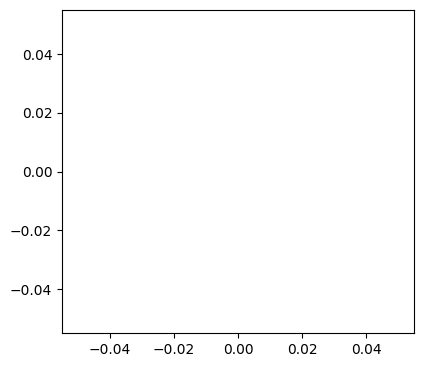

In [ ]:
histogram_boxplot(df_train)

In [ ]:
correlation_matrix= df_train.corr(method="spearman")
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Корреляционная матрица')
plt.tight_layout()
plt.show()

In [ ]:
phik_overview = phik.phik_matrix(df_train)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

# Обучение модели и подчсет метрик

## Линейная регрессия

### Функции подсчета метрик

In [ ]:
def rmse_scorer(y_true, y_pred):
    """Функция вычисления RMSE."""
    mse = mean_squared_error(y_true, y_pred)
    result = np.sqrt(mse)
    return result

def get_metrics_from_cross_validate(pipeline, X_train, y_train, kf):

    cv_metrics = cross_validate(
        estimator=pipeline,
        X=X_train,
        y=y_train,
        cv=kf,
        scoring='r2',
        return_train_score=True,
        n_jobs=-1
    )

    pol_train_score = cv_metrics['train_score'].mean()
    pol_test_score = cv_metrics['test_score'].mean()

    return pol_train_score, pol_test_score

### Линейная регрессия

In [ ]:
x = df_train.drop(columns=["flood_probability"], axis=1)
y = df_train["flood_probability"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.3,
    shuffle=True,
    random_state=42
)

In [ ]:
pipeline = Pipeline([
    ("preprocessor", None),
    ("model", LinearRegression())
])

### Сравнение данных без обработки и с ней

Значение R^2 = 0.84488 оказалось практически равным без предобработки, с StandardScaler() и MinMaxScaler()

In [ ]:
params = {
    "model": [LinearRegression()],
    "preprocessor": [None, StandardScaler(), MinMaxScaler()]
}

In [ ]:
gs = GridSearchCV(
    pipeline,
    param_grid=params,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

In [ ]:
gs.fit(X_train, y_train)
print("Best params", gs.best_params_)
print("Best score", gs.best_score_)

Best params {'model': LinearRegression(), 'preprocessor': None}
Best score 0.8448855849050846


In [ ]:
model = gs.best_estimator_
model

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Коэффициенты линейной регрессии оказались практически равными. Предположительно, признаки равноважны, так как коэффициенты корреляции околонулевые.

In [ ]:
coefficients = model.named_steps['model'].coef_

print("Коэффициенты:", coefficients)

Коэффициенты: [0.00561303 0.00563955 0.00565527 0.00568852 0.00565785 0.00566277
 0.00565935 0.00564454 0.00564119 0.00565231 0.0056436  0.00563476
 0.00566389 0.00563598 0.00564597 0.00561237 0.0056852  0.00563304
 0.00560894 0.00564624]


### Результаты линейной регрессии на тесте

In [ ]:
y_test_pred = model.predict(X_test)

In [ ]:
rmse_test = rmse_scorer(y_test, y_test_pred)
print(f"Метрика RMSE на тестовых данных равна {rmse_test}")

Метрика RMSE на тестовых данных равна 0.020069587906204785


In [ ]:
mse = mean_squared_error(y_test, y_test_pred)
print(f"Метрика MSE на тестовых данных равна {mse}")

Метрика MSE на тестовых данных равна 0.0004027883587248814


In [ ]:
mae = mean_absolute_error(y_test, y_test_pred)
print(f"Метрика MAE на тестовых данных равна {mae}")

Метрика MAE на тестовых данных равна 0.015787783693329276


In [ ]:
r2 = r2_score(y_test, y_test_pred)
print(f"Метрика R2 на тестовых данных равна {r2}")

Метрика R2 на тестовых данных равна 0.845070099597821


In [ ]:
valid_pred = model.predict(df_test)
df_test["prediction"] = valid_pred
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 745305 entries, 1117957 to 1863261
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   monsoon_intensity                  745305 non-null  int64  
 1   topography_drainage                745305 non-null  int64  
 2   river_management                   745305 non-null  int64  
 3   deforestation                      745305 non-null  int64  
 4   urbanization                       745305 non-null  int64  
 5   climate_change                     745305 non-null  int64  
 6   dams_quality                       745305 non-null  int64  
 7   siltation                          745305 non-null  int64  
 8   agricultural_practices             745305 non-null  int64  
 9   encroachments                      745305 non-null  int64  
 10  ineffective_disaster_preparedness  745305 non-null  int64  
 11  drainage_systems                   74

## Полиномиальная регрессия

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, KFold, train_test_split

In [ ]:
x = df_train.drop(columns=["flood_probability"], axis=1)
y = df_train["flood_probability"]
X_train, X_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.3,
    shuffle=True,
    random_state=42
)

**Проверка для степени 2**

In [ ]:
pipeline = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())

kf = KFold(3, shuffle=True, random_state=42)

r2_metrics_pol = get_metrics_from_cross_validate(pipeline, X_train, y_train, kf)

print(f"Среднее качество на тренировочной выборке и валидации: {r2_metrics_pol}")

Среднее качество на тренировочной выборке и валидации: (np.float64(0.8455233048584027), np.float64(0.8453881096896616))


### Lasso регуляризация

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso
import numpy as np

In [ ]:
pipeline = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2, include_bias=False),
    Lasso(
        random_state=42,
        max_iter=2000
    )
)

param_dist = {
    'lasso__alpha': np.logspace(-4, 2, 50)
}

random_search_lasso = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    scoring='r2',
    n_iter=10,
    n_jobs=-1,
    cv=kf,
    random_state=42
)

random_search_lasso.fit(X_train, y_train)

print(f"Лучшее R2: {random_search_lasso.best_score_}")
print(f"Лучшие параметры: {random_search_lasso.best_params_}")

Лучшее R2: 0.6987958928946331
Лучшие параметры: {'lasso__alpha': np.float64(0.003906939937054617)}


In [ ]:
best_pipeline_lasso = random_search_lasso.best_estimator_

r2_metrics_pol_lasso = get_metrics_from_cross_validate(best_pipeline_lasso, X_train, y_train, kf)

###  Ridge регуляризация

In [ ]:
from sklearn.linear_model import Ridge

pipeline = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2, include_bias=False),
    Ridge(random_state=42)
)

param_dist = {
    'ridge__alpha': np.logspace(-4, 2, 50)
}

random_search_ridge = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    scoring='r2',
    n_iter=10,
    n_jobs=-1,
    cv=kf,
    random_state=42
)

random_search_ridge.fit(X_train, y_train)

print(f"Лучшее R2: {random_search_ridge.best_score_}")
print(f"Лучшие параметры: {random_search_ridge.best_params_}")

Лучшее R2: 0.8453881148705281
Лучшие параметры: {'ridge__alpha': np.float64(32.3745754281764)}


In [ ]:
best_pipeline_ridge = random_search_ridge.best_estimator_

r2_metrics_pol_ridge = get_metrics_from_cross_validate(best_pipeline_ridge, X_train, y_train, kf)

### ElasticNet регуляризация

In [ ]:
from sklearn.linear_model import ElasticNet

pipeline = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), ElasticNet(random_state=42))

param_dist = {
    'elasticnet__alpha': np.logspace(-3, 2, 20),
    'elasticnet__l1_ratio': np.linspace(0.1, 0.9, 9)
}

random_search_el = RandomizedSearchCV(pipeline,
                                   param_distributions=param_dist,
                                   scoring='r2',
                                   n_iter=10,
                                   n_jobs=-1,
                                   cv=kf,
                                   random_state=42)

random_search_el.fit(X_train, y_train)

print(f"Лучшее R2: {random_search_el.best_score_}")
print(f"Лучшие параметры: {random_search_el.best_params_}")

KeyboardInterrupt: 

In [ ]:
best_pipeline_el = random_search_el.best_estimator_

r2_metrics_pol_el = get_metrics_from_cross_validate(best_pipeline_el, X_train, y_train, kf)

## Логистическая регрессия

**Идея разбить вероятность наводнения на категории:**


1.   Вероятность наводнения низкая 0<p<0.2
2.   Вероятность наводнения средняя 0.2<p<0.5
3.   Вероятность наводнения высокая 0.5<p<0.8
4.   Вероятность наводнения очень высокая 0.8<p<1

Результат оказался бесполезным, так как значение flood_probability лежит на промежутке 0.275 0.725. Можно перебрать разные значения границ параметров.

In [ ]:
def categorical_target(data):
    if 0 < data <= 0.2:
        return 1
    elif 0.2 < data <= 0.5:
        return 2
    elif 0.5 < data < 0.8:
        return 3
    else:
         return 4

In [ ]:
df_train["target"] = df_train["flood_probability"].apply(categorical_target)

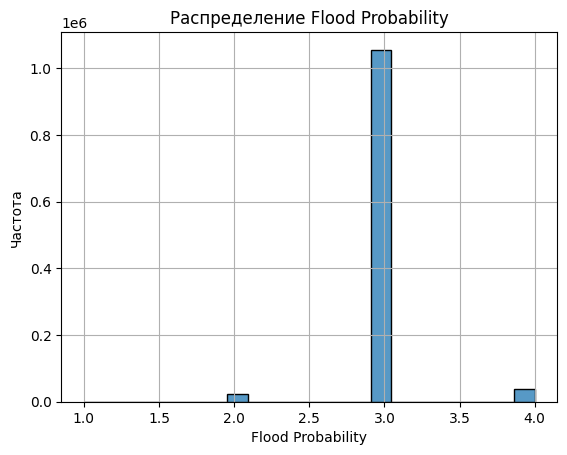

In [ ]:
plt.figure()
sns.histplot(df_train["target"])
plt.title('Распределение Flood Probability')
plt.xlabel('Flood Probability')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [ ]:
x = df_train.drop(columns=["flood_probability", "target"])
y = df_train.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
     x,
     y,
     test_size=0.3,
     shuffle=True,
     random_state=42,
     stratify=y
 )

In [ ]:
lr = LogisticRegression(random_state=42)

In [ ]:
lr.fit(X_train, y_train)
pred = lr.predict(X_train)
accuracy = accuracy_score(y_train, pred)
accuracy

0.887180555324834

In [ ]:
pred_test = lr.predict(X_test)
accuracy_test = accuracy_score(y_test, pred_test)
accuracy_test

0.8878701682827054

## Пока не готовы презентовать

In [ ]:
#! pip install torch torchvision --index-url https://download.pytorch.org/whl/cu130

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class WaterNet(torch.nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons1, n_hidden_neurons2, n_out_neurons):
        super().__init__()
        self.layer1 = torch.nn.Linear(n_in_neurons, n_hidden_neurons1)
        self.bn1 = torch.nn.BatchNorm1d(n_hidden_neurons1)
        self.fact1 = torch.nn.ReLU()

        self.layer2 = torch.nn.Linear(n_hidden_neurons1, n_hidden_neurons2)
        self.bn2 = torch.nn.BatchNorm1d(n_hidden_neurons2)
        self.fact2 = torch.nn.ReLU()

        self.layer3 = torch.nn.Linear(n_hidden_neurons2, n_out_neurons)

    def forward(self, x):
        x = self.layer1(x)
        x = self.fact1(x)
        x = self.bn1(x)

        x = self.layer2(x)
        x = self.fact2(x)
        x = self.bn2(x)

        x = self.layer3(x)

        return x

In [ ]:
def rmse_score(y_pred, y_true):
    """Функция вычисления RMSE."""
    mse_loss = torch.nn.MSELoss()
    loss = mse_loss(y_pred, y_true)
    return torch.sqrt(loss)

In [ ]:
def r2_score_pytorch(y_true, y_preds):
    SS_residual = torch.sum((y_true - y_preds)**2)
    SS_total = torch.sum((y_true - torch.mean(y_true))**2)
    r2 = 1 - SS_residual / SS_total
    return r2

In [ ]:
net = WaterNet(20, 14, 8, 1)
net.to(device)

WaterNet(
  (layer1): Linear(in_features=20, out_features=14, bias=True)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fact1): ReLU()
  (layer2): Linear(in_features=14, out_features=8, bias=True)
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fact2): ReLU()
  (layer3): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
X_train = torch.FloatTensor(X_train.values).to(device)
X_test = torch.FloatTensor(X_test.values).to(device)
y_train = torch.FloatTensor(y_train.values).to(device)
y_test = torch.FloatTensor(y_test.values).to(device)

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 20000

best_loss_value = float('inf')
best_preds = None
best_epoch = -1

for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    preds = net.forward(X_train).flatten()
    preds = preds.squeeze(-1)
    loss_value = rmse_score(y_train, preds)
    loss_value.backward()
    optimizer.step()
    if epoch % 1000 == 0 or epoch == num_epochs - 1:
        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            test_preds = test_preds.squeeze(-1)
            rmse = rmse_score(test_preds, y_test)
            if rmse < best_loss_value:
                best_loss_value = rmse.item()
                best_preds = test_preds.clone().detach()
                best_epoch = epoch
                torch.save(net.state_dict(), f'weights/water_net_epoch_{epoch}_weights.pt')
            print(f"Эпоха: {epoch} RMSE: {rmse}")

torch.save(net.state_dict(), 'weights/water_net_final_weights.pt')
print(f'Лучший RMSE: {best_loss_value}, найден на эпохе: {best_epoch}')

RuntimeError: Parent directory weights does not exist.

In [ ]:
# Загружаем состояние модели (только веса)
loaded_state_dict = torch.load('weights/water_net_epoch_19999_weights.pt')
net.load_state_dict(loaded_state_dict)

df_test_new = df_test.drop(columns=["prediction"])
df_test_tensor = torch.FloatTensor(df_test_new.values).to(device)
# Переводим модель в режим eval (отключаются dropout и batchnorm)
net.eval()

# Подготовили данные из нового файла (new_data)
predictions = net(df_test_tensor)

# Приводим предсказанные значения к удобному виду
final_predictions = predictions.detach().cpu().numpy()

In [ ]:
df_test_new["prediction"] = final_predictions
df_test_new.head()

In [ ]:
best_r2_value = float('-inf')
best_preds = None
best_epoch = -1

for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()

    preds = net.forward(X_train).flatten()
    preds = preds.squeeze(-1)

    train_r2 = r2_score_pytorch(y_train, preds)

    neg_train_r2 = -train_r2
    neg_train_r2.backward()
    optimizer.step()

    if epoch % 1000 == 0 or epoch == num_epochs - 1:
        net.eval()

        with torch.no_grad():
            test_preds = net.forward(X_test)
            test_preds = test_preds.squeeze(-1)

            test_r2 = r2_score_pytorch(y_test, test_preds)

            if test_r2 > best_r2_value:
                best_r2_value = test_r2.item()
                best_preds = test_preds.clone().detach()
                best_epoch = epoch
                torch.save(net.state_dict(), f'weights/water_net_epoch_{epoch}_weights.pt')
            print(f"Эпоха: {epoch}, R²: {test_r2}")

torch.save(net.state_dict(), 'weights/water_net_final_weights.pt')
print(f'Лучший R²: {best_r2_value} найден на эпохе: {best_epoch}')

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [ ]:
best_rmse = float('inf')
best_model_state_dict = None
for epoch in range(num_epochs):
    net.train()
    total_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs).squeeze(-1)
        loss = rmse_score(outputs, targets)  # RMS Error
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Периодически оцениваем качество на тестовых данных
    if epoch % 1000 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = []
        true_values = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = net(inputs).squeeze(-1)
                test_preds.append(outputs.cpu())
                true_values.append(targets.cpu())

        test_preds = torch.cat(test_preds)
        true_values = torch.cat(true_values)
        current_rmse = rmse_score(true_values, test_preds)

        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_model_state_dict = net.state_dict()

        print(f"Эпоха: {epoch}, Текущий RMSE: {current_rmse:.4f}")

In [ ]:
for epoch in range(num_epochs):
    net.train()
    total_neg_r2 = 0.0  # Суммарная потеря (-R²) за эпоху
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs).squeeze(-1)
        # Минус R² используется для минимизации (оптимизационные алгоритмы стремятся уменьшить значение)
        neg_r2 = -r2_score(targets.cpu().numpy(), outputs.detach().cpu().numpy())
        neg_r2 = torch.tensor(neg_r2, requires_grad=True, device=device)
        neg_r2.backward()
        optimizer.step()
        total_neg_r2 += neg_r2.item()

    avg_neg_r2 = total_neg_r2 / len(train_loader)

    # Периодическое тестирование на тестовом наборе
    if epoch % 1000 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = []
        true_values = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = net(inputs).squeeze(-1)
                test_preds.append(outputs.cpu())
                true_values.append(targets.cpu())

        test_preds = torch.cat(test_preds)
        true_values = torch.cat(true_values)
        current_r2 = r2_score(true_values, test_preds)

        if current_r2 > best_r2_value:
            best_r2_value = current_r2
            best_model_state_dict = net.state_dict()

        print(f"Эпоха: {epoch}, Текущий R²: {current_r2:.4f}")